In [1]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm


In [2]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/03_model_weights/resnet"
MODEL_NAME = "20240322_1039"

In [3]:
IMG_SIZE = 128
EMBEDDING_SIZE = 512 

In [4]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [5]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [6]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


FileNotFoundError: [Errno 2] No such file or directory: '/home/vblot/multiaccurate_cp/data/04_predictions/cal/pred_probas'

In [7]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vblot/multiaccurate_cp/data/04_predictions/test/pred_probas'

In [9]:
test_res_emb.shape

(2300, 512)

In [10]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]

In [11]:
cal_labels.shape, cal_res_emb.shape, cal_pred_probas.shape

((1225, 128, 128), (1225, 512), (1225, 128, 128))

In [12]:
cal_labels.max(), cal_pred_probas.max()

(1.0, 0.999923586845398)

In [13]:
ALPHA = .1
N = len(cal_labels)


def I_prime(y, y_pred, u):
    if y_pred.ndim == 2:
        y_pred_th = (y_pred[:, :, np.newaxis] > u).astype(int)
        loss = 1 - (y_pred_th * y[:, :, np.newaxis]).sum(axis=(0, 1)) / y.sum()
    else:
        y_pred_th = (y_pred > u[:, np.newaxis, np.newaxis]).astype(int)
        loss = 1 - (y_pred_th * y).sum(axis=(1, 2)) / y.sum(axis=(1, 2))
    return loss - (ALPHA - 1/N)

def I_prime_vec(y, y_pred, u, batch_size=100):
    n = y.shape[0]
    n_batch = n // batch_size
    i_primes = np.zeros((n, len(u)))
    for i in tqdm(range(n_batch)):
        u_batch = u[i*batch_size:(i+1)*batch_size]
        y_batch = y[i*batch_size:(i+1)*batch_size]
        y_pred_batch = y_pred[i*batch_size:(i+1)*batch_size]
        y_pred_batch = y_pred_batch[:, :, :, np.newaxis]
        y_pred_batch = np.repeat(y_pred_batch, len(u_batch), axis=3)
        y_pred_batch_th = (y_pred_batch > u_batch[:, np.newaxis, np.newaxis, :]).astype(int)
        loss = 1 - (y_pred_batch_th * y_batch[:, :, :, np.newaxis]).sum(axis=1) / y_batch[:, :, :, np.newaxis].sum(axis=1)
        i_primes[i*batch_size:(i+1)*batch_size] = loss - (ALPHA - 1/N)
    return i_primes


def I_prime_vec_fixed_quad(y, y_pred, u):
    
    y_pred_th = (y_pred[:, :, :, np.newaxis] > u).astype(int)
    loss = 1 - (y_pred_th * y[:, :, :, np.newaxis]).sum(axis=1) / y[:, :, :, np.newaxis].sum(axis=1)
    return loss - (ALPHA - 1/N)

def I_prime_vec_fixed_quad_batch(y, y_pred, u, batch_size=100):
    n = y.shape[0]
    n_batch = n // batch_size
    res = np.zeros((n, len(u)))
    for i in range(n_batch):
        res[i*batch_size:(i+1)*batch_size] = I_prime_vec_fixed_quad(y[i*batch_size:(i+1)*batch_size], y_pred[i*batch_size:(i+1)*batch_size], u)
    if n_batch * batch_size < n:
        res[n_batch * batch_size:] = I_prime_vec_fixed_quad(y[n_batch * batch_size:], y_pred[n_batch * batch_size:], u)
    return res

In [14]:
from multiprocessing import Pool


In [15]:
range(10, N)

range(10, 1225)

In [16]:
def integrate_i(y_i, y_pred_i, us_i):
    return integrate.fixed_quad(
            lambda theta_prime: I_prime(y_i, y_pred_i, theta_prime),
            0, us_i, n=100
        )[0]

In [17]:
def I_vec_uni(y, y_pred, emb, theta):
    us = emb @ theta
    integrals = np.zeros(len(y))
    for index in tqdm(range(len(y))):
        integrals[index] = integrate.fixed_quad(
            lambda theta_prime: I_prime(y[index], y_pred[index], theta_prime),
            0, us[index], n=100
        )[0]
    return integrals

def I_vec_multi_proc(y, y_pred, emb, theta):
    us = emb @ theta
    
    with Pool(20) as p:
        data = [(y[i], y_pred[i], us[i]) for i in range(len(y))]
        integrals = p.starmap(integrate_i, data)
    return integrals


In [18]:
def J2(theta, y, y_pred, emb):
    integral = I_vec_multi_proc(y, y_pred, emb, theta)
    return  np.mean(integral)
def J(theta, y, y_pred, emb):
    integral = I_vec_uni(y, y_pred, emb, theta)
    return  np.mean(integral)

In [19]:
np.linspace(0, [1, 2, 3], 100).shape

(100, 3)

In [20]:
init_test = np.random.uniform(0, 1, EMBEDDING_SIZE)


In [21]:
J2(init_test, cal_labels, cal_pred_probas, cal_res_emb)

38.79873487413564

In [22]:
J(init_test, cal_labels, cal_pred_probas, cal_res_emb)

  0%|          | 0/1225 [00:00<?, ?it/s]

 95%|█████████▍| 1159/1225 [00:05<00:00, 225.79it/s]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


100%|██████████| 1225/1225 [00:05<00:00, 224.31it/s]


38.79873487413564

In [23]:
def J_prime(theta, y, y_pred, emb):
    return  np.mean(emb * np.array(I_prime(y, y_pred,emb @ theta)).reshape(-1, 1), axis=0)

In [24]:
J_prime(np.random.uniform(0, 1, EMBEDDING_SIZE), cal_labels, cal_pred_probas, cal_res_emb).shape

(512,)

In [25]:
result = minimize(
    J2, np.random.uniform(0, 1, EMBEDDING_SIZE),
    # bounds=[(0, 1)] * N_GROUPS,
    args=(cal_labels, cal_pred_probas, cal_res_emb), jac=J_prime,
)

In [26]:
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -0.010664881391997083
        x: [-5.805e-01 -1.479e-01 ... -3.227e-01 -3.023e-01]
      nit: 166
      jac: [-1.414e-04 -4.815e-05 ... -8.892e-05 -6.228e-05]
 hess_inv: [[ 1.414e+01  1.139e+01 ...  2.452e+00 -5.231e+00]
            [ 1.139e+01  1.317e+01 ...  3.078e+00 -3.806e+00]
            ...
            [ 2.452e+00  3.078e+00 ...  2.941e+00 -2.109e+00]
            [-5.231e+00 -3.806e+00 ... -2.109e+00  7.849e+00]]
     nfev: 261
     njev: 253

In [27]:
ths = (test_res_emb @ result.x).reshape(-1, 1, 1)

In [28]:
test_res_emb.shape

(2300, 512)

In [29]:
y_pred_test_th = (test_pred_probas >= ths).astype(int)
recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)

/tmp/ipykernel_18660/1774683259.py:2: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)


In [30]:
np.nanmean(recall_test), 1 - ALPHA + 1/N

(0.8909607964454872, 0.9008163265306123)

In [31]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

/tmp/ipykernel_18660/3317103724.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)


0.6778373112805691

(array([  2.,   4.,   4.,   6.,  25.,  20.,  46.,  86.,  77.,  33.,  22.,
         18.,  18.,  12.,  10.,  23.,  21.,  12.,  17.,  18.,  32.,  41.,
         30.,  38.,  53.,  30.,  31.,  29.,  24.,  27.,  26.,  22.,  30.,
         37.,  37.,  38.,  26.,  28.,  30.,  46.,  92., 142.,  70.,  19.,
         17.,  16.,  13.,  16.,  16.,  15.,  17.,  14.,  17.,  21.,  12.,
         15.,  23.,  16.,  20.,  15.,  28.,  18.,  18.,  21.,  28.,  23.,
         21.,  19.,  24.,  25.,  20.,  25.,  25.,  19.,  23.,  17.,  22.,
         26.,  22.,  39.,  35.,  40.,  21.,  12.,   6.,   7.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.0533695 , -0.04528255, -0.0371956 , -0.02910865, -0.0210217 ,
        -0.01293475, -0.0048478 ,  0.00323915,  0.0113261 ,  0.01941305,
         0.0275    ,  0.03558695,  0.0436739 ,  0.05176085,  0.0598478 ,
         0.06793475,  0.0760217 ,  0.08410865,  0.09219561,  0.10028256,
         0.10836951,  0.11

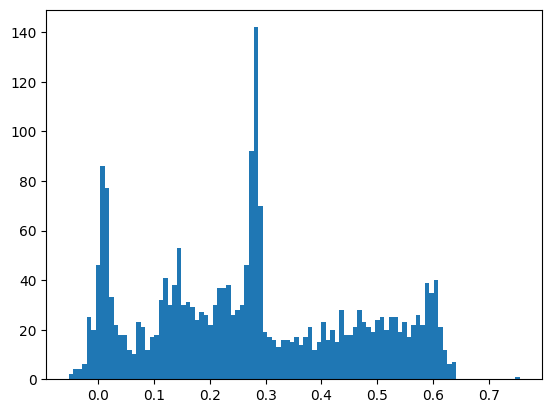

In [32]:
plt.hist(ths[:, 0, 0], bins=100)

(array([287.,  19.,  21.,  47.,  49.,  90., 241., 606., 508., 432.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

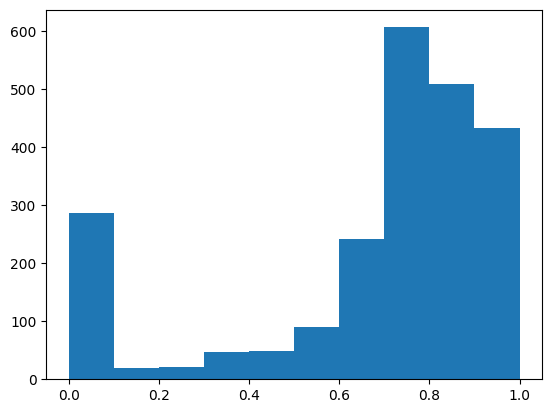

In [33]:
plt.hist(precision_test)

In [34]:
precision_test.shape

(2300,)

In [35]:
np.median(precision_test)

0.7716185878267516